In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

# Initialization

In [2]:
region_map = gpd.read_file('/home/cdecastro/region_shapefile/Regions.shp') #shapefile of region map of the Philippines

In [3]:
reg_names = region_map['REGION'].values #Philippine regions

In [4]:
#accumulated election results per region
data1 = pd.read_csv('/home/cdecastro/election2016/sen-per-region-per-precinct-with-accumulated-results.csv',delimiter='\t')

#read csv file containing election results
header = np.array(['clustered_precinct','position_code','candidate','party','votes','ballot order','total_ballots','H','I','date_time'])
data2 = pd.read_csv('/home/cdecastro/election2016/results_nle2016_05122016_1545.csv',names=header)

## Getting region names from shapefile

Region names from the shapefile and from the election data are different. We changed the names in the shapefile to match the election data

In [5]:
def reg_num(reg_name):
    if reg_name[-1] == ')':
        index = 0
        
        for letter in reg_name[::-1]:
            if letter == '(':
                break
            else:
                index -= 1

        return reg_name[index:-1]
    
    else:
        return 'NCR'

In [6]:
regions = []
for name in reg_names:
    regions.append(reg_num(name).upper())
    
region_map['REGION NUMBER'] = regions

## Creating matrix of normalized fraction of votes

In [7]:
pos_code = 399009 #position code corresponding to senators
senators = data2[data2.position_code == pos_code]
senators['vote fraction'] = senators['votes']/senators['total_ballots']

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
precincts = senators.clustered_precinct.unique()
parties = senators.party.unique().tolist()
candidates = senators.candidate.unique()

candidate_frac = [] #fraction of candidate votes per precicnt
prec_region = [] #region per precinct
ballot_count = [] #total ballot count per precinct

In [9]:
for pr in precincts:
    #get the election data per precinct
    spec_prec = senators[senators.clustered_precinct == pr]
    
    #get the corresponding region of that precinct
    prec_region.append(data1[data1.precincts_code == pr]['region_name'].values[0])
    
    vote_frac_can = [] #candidate vote fractions for each precint
    ballots = max(spec_prec.total_ballots)
    
    for ca in candidates:
        spec_can = spec_prec[spec_prec.candidate == ca]
        vote_frac_can.append(spec_prec['vote fraction'].values) #fraction of votes for each precinct
    
    ballot_count.append(ballots)
    candidate_frac.append(vote_frac_can) #candidate fraction of votes per precinct 

## Creating dataframe of final results

We now create a dataframe containing the overall results or total votes per candidate. 

In [11]:
column_headers = ['candidate','total_votes']
candidate_results = pd.DataFrame(columns=column_headers)

candidate_results['candidate'] = candidates
total_votes = [] 

for can in candidates:
    total_votes.append(senators[senators.candidate == can].votes.sum()) #total votes per candidate
    
candidate_results['total_votes'] = total_votes

final_winners_by_votes = candidate_results.sort_values('total_votes',ascending=False)

In [12]:
final_winners_by_votes[:12]

,candidate,total_votes
26,"VILLANUEVA, JOEL TESDAMAN (LP)",1044413
12,"DRILON, FRANK (LP)",1027590
0,"SOTTO, VICENTE (NPC)",988587
35,"LACSON, PANFILO PING (IND)",965806
32,"GORDON, DICK (IND)",962738
18,"HONTIVEROS, RISA (AKBYN)",899784
16,"ZUBIRI, MIGZ (IND)",890822
34,"PANGILINAN, KIKO (LP)",886170
42,"GATCHALIAN, WIN (NPC)",854296
7,"PACQUIAO, MANNY (UNA)",851901


In [13]:
final_candidates = final_winners_by_votes['candidate'].values #candidates arranged from most to least total votes

In [14]:
# np.save('2016_candidates.npy',final_candidates)

# Sorting matrix from highest to lowest candidate

In [15]:
sorted_results = pd.DataFrame(candidate_frac,columns=candidate_results.total_votes.tolist())
cand_list = pd.DataFrame([final_candidates],columns=candidate_results.total_votes.tolist())
sorted_results = sorted_results.append(cand_list,ignore_index=True)

sorted_votes = np.flip(np.array(sorted_results[sorted(sorted_results)].columns.tolist()))
sorted_results = sorted_results[sorted_votes]

# Plotting Archetypes and Weight Distribution

In [16]:
def archetype_plots(arc_senators,abundance):    
    weight_sum = [] 
    normalization = []
    pos = np.arange(sen_num) #create array total number of senators

    for n in range(arc_senators.shape[1]): #plotting per archetype
        sorted_arc = arc_senators[n]
        
        peak = max(sorted_arc) #get maximum vote intensity per archetype
        mean = np.mean(sorted_arc) #get mean of vote intensities per archetype
        sigma = np.std(sorted_arc) #get standard deviation of vote intensities per archetype
        
        plt.figure(figsize=(8.5,6))
        
        ax1 = plt.axes()  # standard axes
        ax2 = plt.axes([0.60, 0.625, 0.26, 0.24])
        
        ax1.bar(pos,sorted_arc/peak) #normalize vote intensities
        ax1.axhline((mean+sigma)/peak,color='black',linestyle='--',label='$\mu + \sigma$') #plot the mean+one standard dev line
        ax1.set_xticks(np.arange(0,sen_num+1,5))
        ax1.set_xlabel('candidate',fontsize=14)
        ax1.set_ylabel('intensity',fontsize=14)
        ax1.grid(b=True,axis='both')
        ax1.margins(0.03)
        ax1.legend(loc='lower right')
        
        histogram = np.histogram(peak*abundance[n],bins=40) #plot the weight distribution as an inset
        ax2.bar(histogram[1][:-1],histogram[0]/len(abundance[n]),width=np.diff(histogram[1])[0],color='mediumseagreen')
        ax2.set_ylabel('frequency',fontsize=10)
        ax2.set_xlabel('weights',fontsize=10)
        ax2.set_xticks(np.arange(0,1.2,0.4))
        ax2.set_xlim(0,0.8)
        
#         plt.savefig('archetype_'+str(n+1)+'.png',dpi=600,bbox_inches='tight')
        plt.show()
    
        weight_sum.append(np.sum(abundance[n])) #sum of weights per archetype
        normalization.append(peak) #store the maximum vote intensity per archetype
        
    return weight_sum,normalization

# Looking at endmember signatures for MVSA

In [17]:
MVSA_senators = pd.read_csv('/home/cdecastro/Election Results 2016/MVSA_senators_.csv',header=None)

MVSA_abundance = pd.read_csv('/home/cdecastro/Election Results 2016/MVSA_abundances_.csv',header=None).values

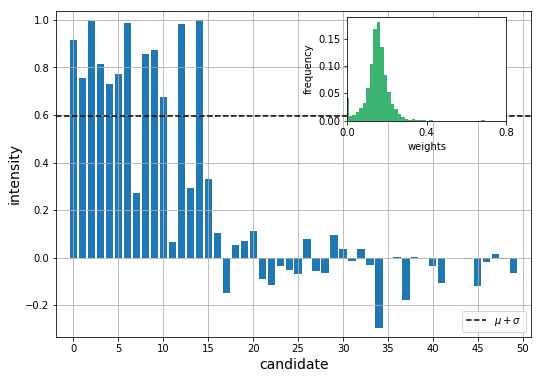

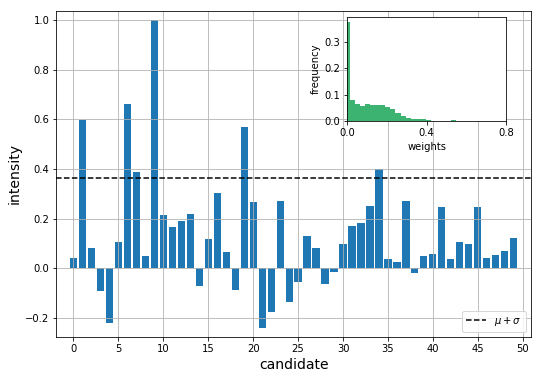

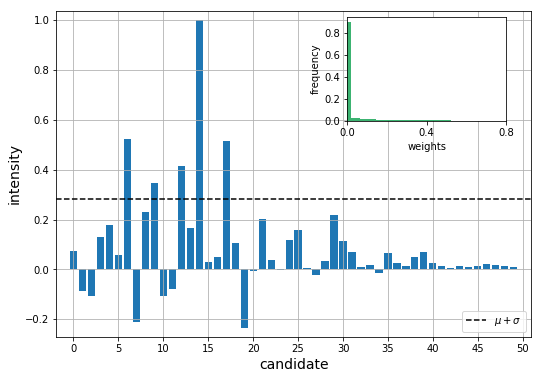

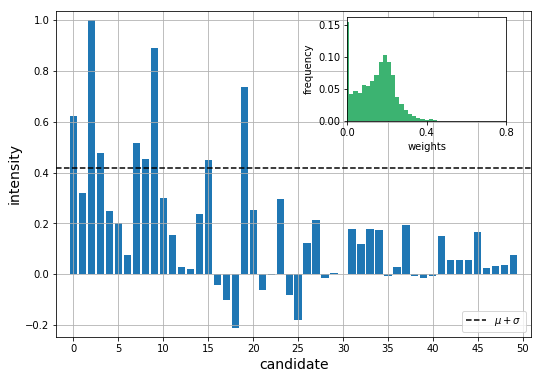

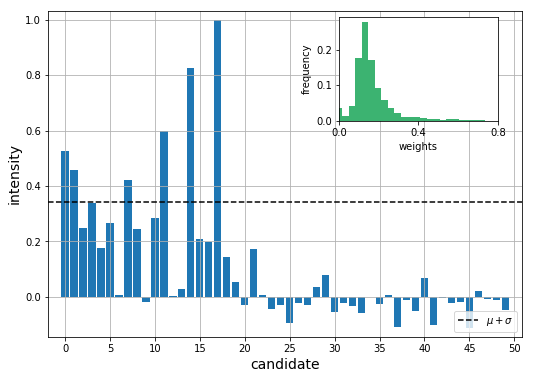

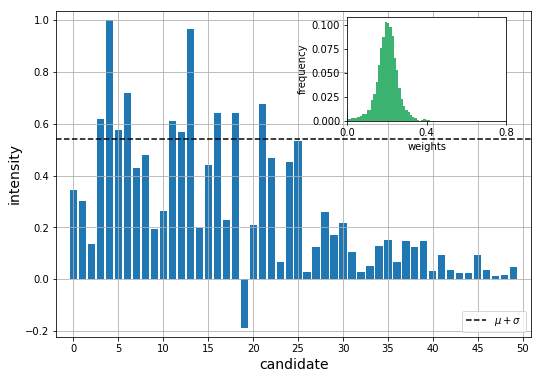

In [18]:
sen_num = len(MVSA_senators) #len(sorted_results.values[-1])

weight_sum_MVSA, MVSA_normalization = archetype_plots(MVSA_senators,MVSA_abundance)

## Archetype with highest sum of weights.

In [19]:
print('Archetype',np.argmax(weight_sum_MVSA)+1,'has the most weights sum.')

Archetype 6 has the most weights sum.


## List of candidates from highest to lowest

In [20]:
final_candidates

array(['VILLANUEVA, JOEL TESDAMAN (LP)', 'DRILON, FRANK (LP)',
       'SOTTO, VICENTE (NPC)', 'LACSON, PANFILO PING (IND)',
       'GORDON, DICK (IND)', 'HONTIVEROS, RISA (AKBYN)',
       'ZUBIRI, MIGZ (IND)', 'PANGILINAN, KIKO (LP)',
       'GATCHALIAN, WIN (NPC)', 'PACQUIAO, MANNY (UNA)',
       'RECTO, RALPH (LP)', 'DE LIMA, LEILA (LP)',
       'TOLENTINO, FRANCIS (IND)', 'OSME?A, SERGIO III (IND)',
       'ROMUALDEZ, MARTIN (LAKAS)', 'DOMAGOSO, ISKO MORENO (PMP)',
       'GUINGONA, TG (LP)', 'PETILLA, CARLOS JERICHO (LP)',
       'COLMENARES, NERI (MKBYN)', 'LAPID, MARK (AKSYON)',
       'MANZANO, EDU (IND)', 'ROMULO, ROMAN (IND)', 'OPLE, SUSAN (NP)',
       'LACSAMANA, ALMA MORENO (UNA)', 'BELGICA, GRECO (IND)',
       'ALUNAN, RAFFY (IND)', 'GADON, LARRY (KBL)', 'LANGIT, REY (UNA)',
       'KAPUNAN, ATTY. LORNA (AKSYON)', 'PAGDILAO, SAMUEL (IND)',
       'SANTIAGO, DIONISIO (IND)', 'NAPE?AS, GETULIO (UNA)',
       'CHAVEZ, MEL (WPPPMM)', 'MONTANO, ALLAN (UNA)',
       'AMBOLODTO,

## Normalize weights

Since we divided the archetype vote intensities by their maximum values (essentially normalizing them), we have to multiply the same values to the weights to maintain the linear unmixing model.

In [21]:
norm_abundance = np.array(MVSA_normalization)*(MVSA_abundance.T)

## Arrange archetypes according mean of weights

In [22]:
arranged_index = np.flip(np.argsort(np.mean(norm_abundance.T,axis=1))) #calculate the weights mean of each archeytpe

In [23]:
MVSA_2016 = np.copy(MVSA_senators.T)
counter = 0

#arrange archetype sigantures based on obtained indices
for i in arranged_index:
    MVSA_2016[counter] = MVSA_senators.values.T[i]
    counter += 1

In [24]:
#save the arranged archetype signatures into a new .csv file
# np.savetxt('MVSA_2016.csv',MVSA_2016,delimiter=',')

In [25]:
#do the same for weights
arranged_abundance = np.copy(norm_abundance.T)
counter = 0

for i in arranged_index:
    arranged_abundance[counter] = norm_abundance.T[i]
    counter += 1

# Determining dominant archetype per region

In [26]:
def reg_weight(weights,tot_votes):
    #multiply the weights by the total ballot count to account for precincts with higher voting population
    weights = tot_votes*weights  
    
    arc_mean = np.mean(weights,axis=1)
    arc_median = np.median(weights,axis=1)

    #return the index of the archetype with the highest mean and median
    return np.argmax(arc_mean)+1,np.argmax(arc_median)+1

# Dominant archetype per region

In [27]:
region_index = [] #index of precincts per region

#grouping precincts together by region
for r in regions:
    region_index.append(np.where(np.array(prec_region) == r)[0])

In [28]:
# np.save('regions.npy',prec_region)

In [29]:
dom_mean_arc = []
dom_median_arc = []

#calculate the dominant archetype per region
for m in range(len(regions)):
    reg_weights = arranged_abundance.T[region_index[m]] #weights corresponding to each region
    total_v = np.array(ballot_count)[region_index[m]] #ballot counts per precinct in each region

    dom_mean,dom_median = reg_weight(np.array(reg_weights).T,total_v) #determine the dominant archetype using function
    
    dom_mean_arc.append('archetype '+str(dom_mean))
    dom_median_arc.append('archetype '+str(dom_median))

In [30]:
region_map['dom_mean_arc'] = dom_mean_arc
region_map['dom_median_arc'] = dom_median_arc

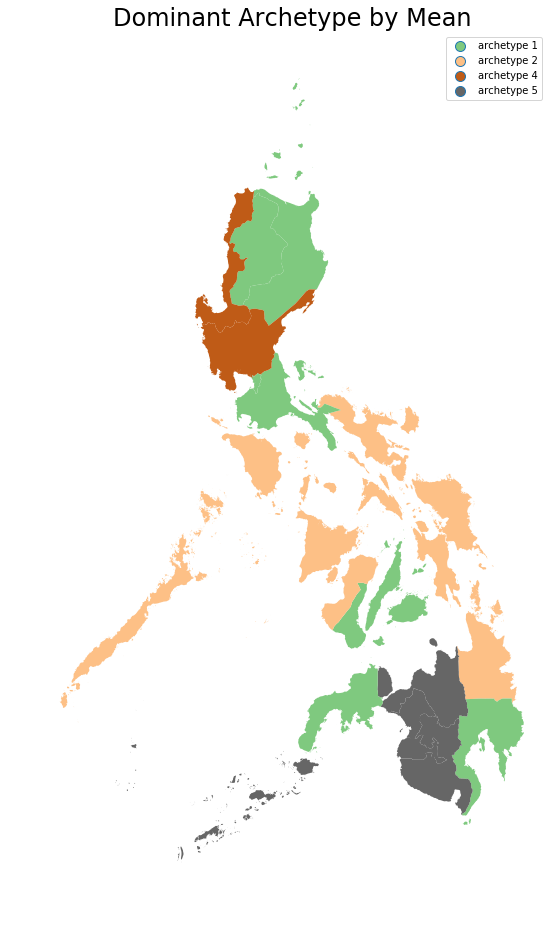

In [31]:
color = plt.get_cmap('Accent',5)
region_map.plot(column='dom_mean_arc',cmap=color,figsize=(18,16),legend=True)
plt.title('Dominant Archetype by Mean',fontsize=24)
plt.axis('off')
# plt.savefig('2016_map_mean.png',bbox_inches='tight',dpi=600)
plt.show()

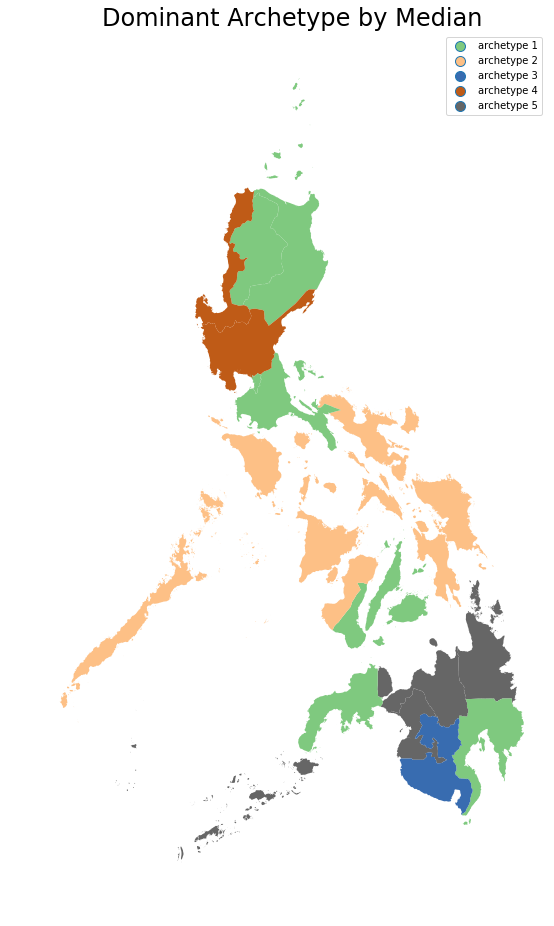

In [32]:
color = plt.get_cmap('Accent',5)
region_map.plot(column='dom_median_arc',cmap=color,figsize=(18,16),legend=True)
plt.title('Dominant Archetype by Median',fontsize=24)
plt.axis('off')
# plt.savefig('2016_map_poster.png',bbox_inches='tight',dpi=300)
plt.show()